#### The other notebook (WA_base_code) does the preprocessing and this one does the modelling

In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import datasets, layers, models, losses
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input

In [3]:
mydata= pd.read_csv(".\\path_to_updated_csv_file.csv")

Let's say we want to test predicting type just based on the images.

In [4]:
def load_process_image(file_path):
    # Load the image and resize it for AlexNet
    img = image.load_img(file_path, target_size=(255, 255))
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array = preprocess_input(img_array)  # Preprocess the image as required by AlexNet
    return img_array

In [5]:
# Find the 6 most frequent types
top_six_types = mydata['type'].value_counts().nlargest(7).index

# Create a subset of the data with only these types
subset_mydata = mydata[mydata['type'].isin(top_six_types)]

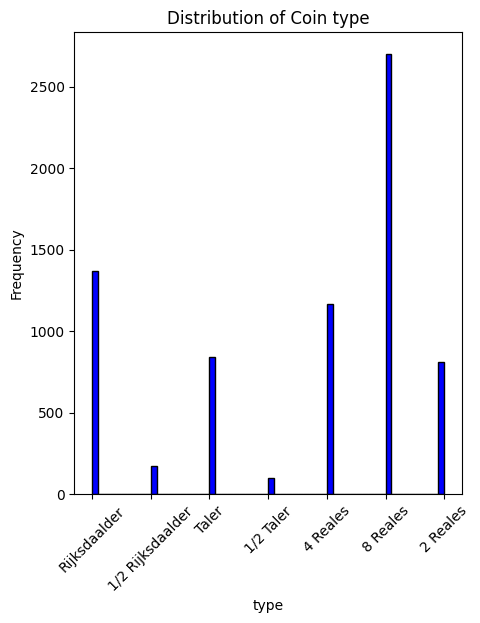

In [7]:
# Plot histogram with a reasonable number of bins
plt.figure(figsize=(5, 6))
plt.hist(subset_mydata['type'], bins=60, color='blue', edgecolor='black')
plt.xlabel('type')
plt.ylabel('Frequency')
plt.title('Distribution of Coin type')
plt.xticks(rotation=45)  # Rotate the labels for better readability
plt.show()

In [24]:
# Preprocess images and extract corresponding classes
image_data = []
for index, row in subset_mydata.iterrows():
    processed_img = load_process_image(row['local_image_path'])
    image_data.append(processed_img)

# Convert to numpy arrays
image_data = np.vstack(image_data)

MemoryError: Unable to allocate 5.21 GiB for an array with shape (7163, 255, 255, 3) and data type float32

In [10]:
from tensorflow.keras.utils import Sequence
import math

class ImageDataGenerator(Sequence):
    def __init__(self, df, batch_size):
        self.df = df
        self.batch_size = batch_size

    def __len__(self):
        return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        batch_df = self.df.iloc[idx * self.batch_size:(idx + 1) * self.batch_size]
        image_batch = [load_process_image(row['local_image_path']) for _, row in batch_df.iterrows()]
        image_batch = np.vstack(image_batch)
        return image_batch

# Example usage
batch_size = 32  # Adjust based on your system's capability
image_data_generator = ImageDataGenerator(subset_mydata, batch_size)

# To access a batch of images
batch_images = image_data_generator[0]  # Get the first batch

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder

#enc = OneHotEncoder(handle_unknown='ignore')
y = pd.get_dummies(subset_mydata['type'])
subset_mydata_no_type = subset_mydata.drop('type', axis=1)
x_train, x_test, y_train, y_test = train_test_split(subset_mydata_no_type, y, test_size=0.2, random_state=42)

In [21]:
X_train = ImageDataGenerator(x_train, batch_size=32)
X_test  = ImageDataGenerator(x_test,  batch_size=32)

In [22]:
import keras
img_height, img_width = 255, 255

num_classes = 7

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

model=keras.models.Sequential([
    keras.layers.Conv2D(filters=128, kernel_size=(11,11), strides=(4,4), activation='relu', input_shape=(img_width,img_height,3)),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Conv2D(filters=256, kernel_size=(5,5), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(3,3)),
    keras.layers.Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(filters=256, kernel_size=(1,1), strides=(1,1), activation='relu', padding="same"),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=(2,2)),
    keras.layers.Flatten(),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(1024,activation='relu'),
    keras.layers.Dropout(0.5),
    keras.layers.Dense(num_classes,activation='softmax')    
    
])
model.compile(optimizer='adam', loss=losses.categorical_crossentropy, metrics=['accuracy']) 

In [ ]:

#history = model.fit(X_train, y_train, batch_size=64, callbacks=[callback], epochs=40, validation_data=(X_test, y_test))

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(36)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

NameError: name 'history' is not defined

In [ ]:
#model.save('models/ALEX_type_7_classes.keras')

In [25]:
model = tf.keras.models.load_model('models/ALEX_type_7_classes.keras')

In [26]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
#Generate predictions with the model using our X values
y_pred = model.predict(X_test)

45/45 [==============================] - 26s 548ms/step


In [27]:
y,levels = pd.factorize(subset_mydata['type'])

In [28]:
levels

Index(['Rijksdaalder', '1/2 Rijksdaalder', 'Taler', '1/2 Taler', '4 Reales',
       '8 Reales', '2 Reales'],
      dtype='object')

In [29]:
#class_names = y_test.columns.to_list()

cf = confusion_matrix(
    y_test.values.argmax(axis=1), y_pred.argmax(axis=1))

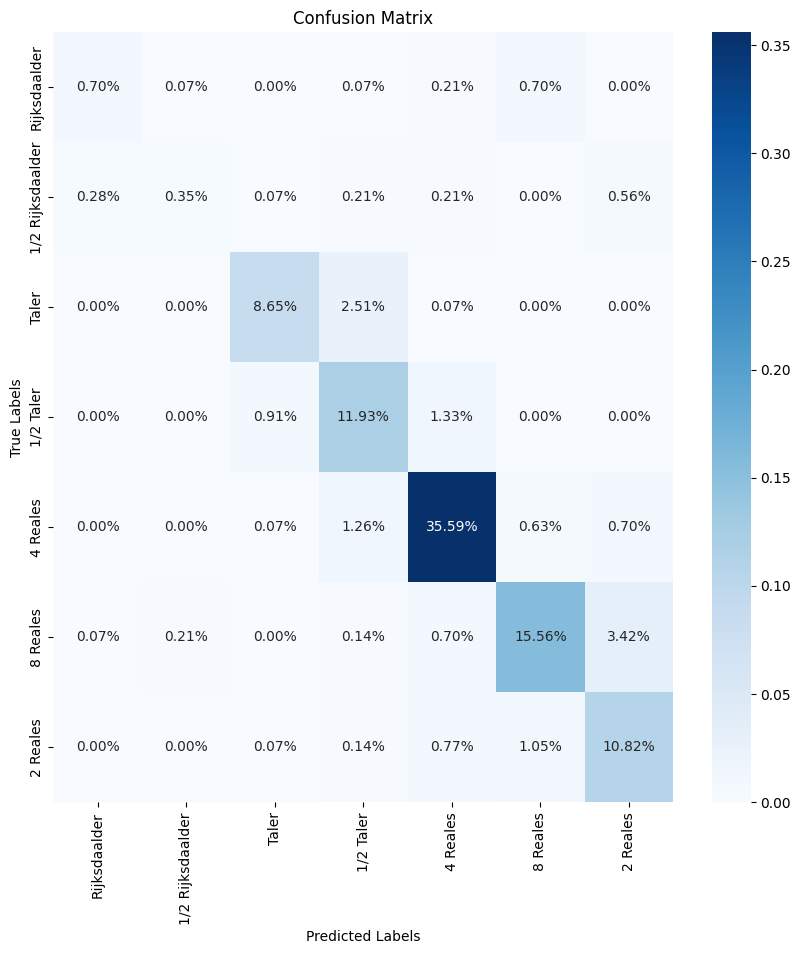

In [30]:
import seaborn as sns
plt.figure(figsize=(10, 10))
sns.heatmap(cf/np.sum(cf), annot=True, 
            fmt='.2%', cmap='Blues', xticklabels=levels, yticklabels=levels)
# Labels for x and y axes
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')

# Title for your confusion matrix
plt.title('Confusion Matrix')

# Show the plot
plt.show()

1/1 [==============================] - 0s 422ms/step


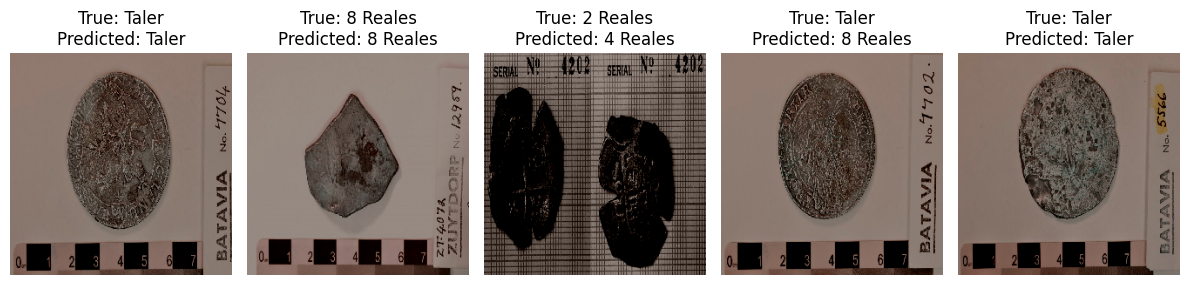

In [49]:
import matplotlib.pyplot as plt
import numpy as np

# Get a batch of test images
test_images = next(iter(X_test))

# Predict labels for these test images
predicted_labels = model.predict(test_images)
predicted_labels = np.argmax(predicted_labels, axis=1)  # Convert predictions to label indices

# Select a few random images to display from this batch
num_samples = 5
indices = np.random.choice(range(len(test_images)), num_samples, replace=False)

# Assuming that 'image_data' contains the processed images and is a NumPy array
image_data = test_images.astype('float32') / 255.0  # Scale images to [0, 1] range if not already done
plt.figure(figsize=(12, 8))
# When displaying the images, ensure they are in the correct format
for i, idx in enumerate(indices):
    plt.subplot(1, num_samples, i + 1)
    # If the images are in channels-first format, convert to channels-last for display
    if image_data.shape[-1] != 3:
        # This assumes that the color channel is the first dimension in the array
        img_to_show = np.transpose(image_data[idx], (1, 2, 0))
    else:
        img_to_show = image_data[idx]

    # Clip the image pixel values to [0, 1] if they are not already
    img_to_show = np.clip(img_to_show, 0, 1)

    plt.imshow(img_to_show)
    
    # Extract the corresponding true label from y_test
    true_label_idx = np.argmax(y_test.iloc[idx])
    true_label = y_test.columns[true_label_idx]
    predicted_label = y_test.columns[predicted_labels[idx]]

    plt.title(f'True: {true_label}\nPredicted: {predicted_label}')
    plt.axis('off')

plt.tight_layout()
plt.show()


In [51]:
predicted = y_pred.argmax(axis=1)
actual = y_test.values.argmax(axis=1)
TP = np.count_nonzero(predicted * actual)
TN = np.count_nonzero((predicted - 1) * (actual - 1))
FP = np.count_nonzero(predicted * (actual - 1))
FN = np.count_nonzero((predicted - 1) * actual)
precision = TP / (TP + FP)
recall = TP / (TP + FN)
f1 = 2 * precision * recall / (precision + recall)
accuracy = (TP + TN) / (TP + TN + FP + FN)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1: ", f1)
print("Accuracy: ", accuracy)

Precision:  0.5008925383791503
Recall:  0.5005351409204424
F1:  0.5007137758743754
Accuracy:  0.5008919015340706


In [ ]:
y_test.values.argmax(axis=1)

array([4, 5, 6, ..., 3, 4, 2], dtype=int64)

In [ ]:
y_pred.argmax(axis=1)

array([4, 5, 6, ..., 3, 4, 2], dtype=int64)

In [52]:
def accuracy(y_true, y_pred):
    
    """
    Function to calculate accuracy
    -> param y_true: list of true values
    -> param y_pred: list of predicted values
    -> return: accuracy score
    
    """
    
    # Intitializing variable to store count of correctly predicted classes
    correct_predictions = 0
    
    for yt, yp in zip(y_true, y_pred):
        
        if yt == yp:
            
            correct_predictions += 1
    
    #returns accuracy
    return correct_predictions / len(y_true)

In [53]:
accuracy(y_test, yConf)

NameError: name 'yConf' is not defined

In [54]:
y_test.columns

Index(['1/2 Rijksdaalder', '1/2 Taler', '2 Reales', '4 Reales', '8 Reales',
       'Rijksdaalder', 'Taler'],
      dtype='object')

In [55]:
y_pred

array([[9.2544025e-03, 7.1202591e-03, 1.1962929e-03, ..., 7.7252299e-01,
        5.6853209e-02, 9.7911663e-02],
       [8.3653815e-02, 3.8743862e-03, 2.0111549e-04, ..., 7.1422528e-03,
        8.3370829e-01, 7.0513338e-02],
       [4.1724135e-09, 9.6490403e-04, 1.4239867e-11, ..., 2.8430516e-06,
        1.8321377e-03, 9.9720013e-01],
       ...,
       [5.7707952e-05, 7.9794600e-06, 8.5228810e-04, ..., 1.4335485e-01,
        1.4809486e-06, 2.5052732e-06],
       [2.8566385e-02, 1.4386903e-02, 3.7744583e-03, ..., 6.9331080e-01,
        7.3109753e-02, 8.0099225e-02],
       [2.1451218e-04, 4.4395681e-04, 8.0329317e-01, ..., 1.2290308e-03,
        1.0663705e-04, 9.9692108e-05]], dtype=float32)

In [56]:
y_pred.argmax(axis=1)

array([4, 5, 6, ..., 3, 4, 2], dtype=int64)

In [57]:
levels

Index(['Rijksdaalder', '1/2 Rijksdaalder', 'Taler', '1/2 Taler', '4 Reales',
       '8 Reales', '2 Reales'],
      dtype='object')

In [58]:
yConf = pd.get_dummies(y_pred.argmax(axis=1), columns=y_test.columns)

In [59]:
yConf

,0,1,2,3,4,5,6
0,False,False,False,False,True,False,False
1,False,False,False,False,False,True,False
2,False,False,False,False,False,False,True
3,False,False,False,False,True,False,False
4,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...
1428,False,False,False,True,False,False,False
1429,False,False,False,False,False,False,True
1430,False,False,False,True,False,False,False
1431,False,False,False,False,True,False,False


In [60]:
y_test

,1/2 Rijksdaalder,1/2 Taler,2 Reales,4 Reales,8 Reales,Rijksdaalder,Taler
5462,False,False,False,False,True,False,False
709,False,False,False,False,False,True,False
251,False,False,False,False,False,False,True
4219,False,False,False,False,True,False,False
7318,False,False,False,True,False,False,False
...,...,...,...,...,...,...,...
5284,False,False,False,False,True,False,False
291,False,False,False,False,False,False,True
6886,False,False,False,True,False,False,False
5769,False,False,False,False,True,False,False
